# keras-sincnet

Speaker Recognition from Raw Waveform with SincNet  
*Mirco Ravanelli, Yoshua Bengio*  
https://arxiv.org/pdf/1808.00158.pdf

## SincConv (slow implementation)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

In [ ]:
class SincConv(Layer):
    '''
    Sinc-based convolution Keras layer

    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    '''

    @staticmethod
    def sinc(band, t_right):
        y_right = K.sin(2 * np.pi * band * t_right) / (2 * np.pi * band * t_right)
        y_left = K.reverse(y_right, 0)
        y = K.concatenate([y_left, K.variable(K.ones(1)), y_right])
        return y

    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq):
        super(SincConv, self).__init__()

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq

        # Set trainable parameters
        self.b1 = self.add_weight(
            name='b1',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band = self.add_weight(
            name='band',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        
        # Initialize weights with cutoff frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(50)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2)
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters)
        hz_points = self.mel_to_hz(mel_points)

        b1 = np.roll(hz_points, 1)
        b1[0] = 30
        b2 = np.roll(hz_points, -1)
        b2[-1] = (self.sample_freq / 2) - 100

        self.set_weights([b1 / self.sample_freq, (b2 - b1) / self.sample_freq])

        # Initialize weights by 0 and the Nyquist frequency
        # low = np.zeros(self.nb_filters)
        # high = np.repeat(self.sample_freq / 2, self.nb_filters)
        # self.set_weights([low / self.sample_freq,
        #                   (high - low) / self.sample_freq])
        
        # Get beginning and end frequencies of the filters
        min_freq = 50.0
        min_band = 50.0
        self.beg_freq = K.abs(self.b1) + min_freq / self.sample_freq
        self.end_freq = self.beg_freq + (K.abs(self.band) + min_band / self.sample_freq)
        
        t_right_linspace = np.linspace(1, (self.kernel_size - 1) / 2, int((self.kernel_size - 1) / 2))
        self.t_right = K.variable(t_right_linspace / self.sample_freq)

        # Hamming window
        n = np.linspace(0, self.kernel_size, num=self.kernel_size)
        window = 0.54 - 0.46 * K.cos(2 * np.pi * n / self.kernel_size)
        window = K.cast(window, "float32")
        self.window = K.variable(window)

    def call(self, X):
        filters = []
        for i in range(self.nb_filters):
            low_pass1 = 2 * self.beg_freq[i] * self.sinc(self.beg_freq[i] * self.sample_freq, self.t_right)
            low_pass2 = 2 * self.end_freq[i] * self.sinc(self.end_freq[i] * self.sample_freq, self.t_right)
            band_pass = low_pass2 - low_pass1
            band_pass = band_pass / K.max(band_pass)

            filters.append(band_pass * self.window)

        filters = K.stack(filters)

        # TF convolution assumes data is stored as NWC
        filters = K.transpose(filters)
        filters = K.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return K.conv1d(X, filters)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConv(1, 9, 400)
y = sinc_layer(X)
print(y.numpy().transpose(0, 2, 1))

[[[0.0931545  0.11644317 0.1397316  0.16302049 0.18630917 0.20959736
   0.23288602 0.25617468 0.27946335 0.30275205 0.3260407  0.34932888
   0.37261754 0.39590624 0.41919488 0.44248354 0.46577224 0.4890609
   0.51234955 0.5356382  0.5589269  0.58221555 0.60550326 0.6287919
   0.65208066 0.67536926 0.69865793 0.7219466  0.74523526 0.768524
   0.7918126  0.81510127 0.83839    0.8616786  0.88496727 0.90825593
   0.9315446  0.95483327 0.97812194 1.0014106  1.0246992  1.0479879
   1.0712767  1.0945653  1.117854   1.1411407  1.1644312  1.187718
   1.2110087  1.2342954  1.2575841  1.2808727  1.3041613  1.32745
   1.3507388 ]]]


## SincConv (fast implementation)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

class SincConvFast(Layer):
    '''
    Sinc-based convolution Keras layer

    Parameters
    ----------
    nb_filters : `int`
        Number of filters (= number of output channels).
    kernel_size : `int`
        Convolution filter width/length (will be increased by one if even).
    sample_freq : `int`
        Sample rate of input audio.
    stride : `int`
        Convolution stride param. Defaults to 1.
    padding : `string`
        Convolution padding param. Defaults to "VALID".
    min_low_hz : `int`
        Minimum lowest frequency for pass band filter. Defaults to 50.
    min_band_hz : `int`
        Minimum frequency for pass band filter. Defaults to 50.

    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    '''

    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        
        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])
      
        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConvFast(2, 9, 400)
y = sinc_layer(X)

print(y.numpy().transpose(0, 2, 1))

[[[-0.073394   -0.09174268 -0.11009065 -0.12843946 -0.14678803
   -0.16513611 -0.18348445 -0.20183372 -0.22018182 -0.23853062
   -0.25687847 -0.27522728 -0.2935761  -0.31192487 -0.3302732
   -0.34862107 -0.36696893 -0.3853177  -0.40366653 -0.42201582
   -0.44036415 -0.45871246 -0.4770608  -0.49540818 -0.51375747
   -0.5321058  -0.5504531  -0.5688024  -0.58715075 -0.60549814
   -0.62384933 -0.6421986  -0.660546   -0.67889243 -0.69724166
   -0.71559286 -0.73394024 -0.75228953 -0.77063596 -0.78898525
   -0.80733454 -0.82568187 -0.84402925 -0.86237663 -0.8807278
   -0.8990771  -0.9174226  -0.9357719  -0.9541212  -0.9724685
   -0.9908197  -1.0091633  -1.0275164  -1.0458599  -1.064215  ]
  [-0.1843509  -0.23043808 -0.27652672 -0.3226144  -0.3687011
   -0.41478878 -0.46087646 -0.50696415 -0.5530528  -0.59913945
   -0.64522713 -0.6913167  -0.7374044  -0.7834883  -0.82957786
   -0.8756655  -0.92175317 -0.96784085 -1.0139285  -1.0600162
   -1.1061039  -1.1521915  -1.1982774  -1.2443688  -1.29045

## Load dataset (LibriSpeech)

**The following preprocessing steps (described in the original article) are not implemented:**

- Non-speech intervals at the beginning and end of each sentence were removed
- The Librispeech sentences with internal silences lasting more than 125 ms were split into multiple chunks.
- For the Librispeech corpus, the training and test material have been randomly selected to exploit 12-15 seconds of training material for each speaker and test sentences lasting 2-6 seconds.

In [ ]:
sample_frequency = 16000 # 16kHz (LibriSpeech)
frame_size = 0.300       # 300ms
frame_stride = 0.01      # 10ms
max_num_frames = 100

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
nb_speakers = 16

print("Input length: {} ({}s)".format(frame_length, frame_size * max_num_frames))
print("Input shape: {}".format((batch_size, frame_length)))

Input length: 4800 (30.0s)
Input shape: (128, 4800)


#### Download LibriSpeech

In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar xf train-clean-100.tar.gz

--2021-03-15 12:33:32--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  11.2MB/s    in 9m 5s   

2021-03-15 12:42:38 (11.2 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [ ]:
from IPython.display import Audio
Audio('LibriSpeech/train-clean-100/1081/128618/1081-128618-0012.flac')

#### Create LibriSpeech generator

In [ ]:
from keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf
import glob

def get_frames_indices(filename):
    signal, fs = sf.read(filename)

    # Determine number of frames
    signal_length = len(signal)
    assert signal_length > frame_length
    num_frames = int(np.floor((signal_length - frame_length) / frame_step))

    # Limit the number of frames
    num_frames = min(num_frames, max_num_frames)

    return np.arange(0, num_frames * frame_step, frame_step)

def load_dataset(data_folder, max_speakers=10, max_utterances=10):
    X = []
    y = []

    files = glob.glob(data_folder)
    for speaker_id in range(min(max_speakers, len(files))):
        speaker_files = glob.glob(files[speaker_id] + '/*')

        nb_utterances_for_speaker = 0

        for sentence_id in range(len(speaker_files)):
            sentence_files = glob.glob(speaker_files[sentence_id] + '/*.flac')

            for utterance_id in range(len(sentence_files)):
                if nb_utterances_for_speaker >= max_utterances:
                    break

                filename = sentence_files[utterance_id]
                frames = get_frames_indices(filename)

                for frame in frames:
                    X.append([filename, frame])
                    y.append(speaker_id)
                
                nb_utterances_for_speaker += 1

    return X, y

class LibrispeechGenerator(Sequence) :
  
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(np.int)
  
    def __getitem__(self, batch_id):
        X_batch = np.zeros((self.batch_size, frame_length, 1))
        y_batch = np.zeros(self.batch_size)

        for i in range(self.batch_size):
            id = batch_id * self.batch_size + i
            if id >= len(self.y):
                id = np.random.randint(0, len(self.y))

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [ ]:
# Load and determine audio filenames and their associated speaker
X_, y_ = load_dataset("LibriSpeech/train-clean-100/*",
                    max_speakers=nb_speakers,
                    max_utterances=8)

# Split in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2)

# Instantiate custom generator to load each batch at once
train_gen = LibrispeechGenerator(X_train, y_train, batch_size)
val_gen = LibrispeechGenerator(X_val, y_val, batch_size)

In [ ]:
print("Number of training batches:", len(train_gen))
print("Number of validation batches:", len(val_gen))

Number of training batches: 80
Number of validation batches: 20


## SincNet

**The model is simplified to avoid overfitting on our subset of LibriSpeech:**

- No LayerNormalization on the input as it prevents the model to converge
- The number of filters is reduced
- 2 conv layers instead of 3
- 2 dense layers instead of 3

### Create model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def create_sincnet(enable_sincconv=True):
    model = Sequential()

    # model.add(LayerNormalization(input_shape=(wlen, 1)))
    if (enable_sincconv):
        model.add(SincConvFast(64, 251, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=32, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))

    model.add(Dense(nb_speakers, activation='softmax'))

    return model

sincnet_model = create_sincnet()

In [ ]:
sincnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sinc_conv_fast_1 (SincConvFa (None, 4550, 64)          253       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1516, 64)          0         
_________________________________________________________________
layer_normalization (LayerNo (None, 1516, 64)          128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1516, 64)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1512, 32)          10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 504, 32)           0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 504, 32)           6

### Train model

In [ ]:
sincnet_model.compile(optimizer=RMSprop(lr=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

history = sincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=5,
                            initial_epoch=0,
                            callbacks=[save_callback])

Epoch 1/5
80/80 [==============================] - 271s 3s/step - loss: 1.9188 - accuracy: 0.4314 - val_loss: 0.8743 - val_accuracy: 0.7621

Epoch 00001: val_loss improved from inf to 0.87426, saving model to ./checkpoints/training-0001.ckpt
Epoch 2/5
80/80 [==============================] - 265s 3s/step - loss: 0.4934 - accuracy: 0.9091 - val_loss: 0.4950 - val_accuracy: 0.8746

Epoch 00002: val_loss improved from 0.87426 to 0.49504, saving model to ./checkpoints/training-0002.ckpt
Epoch 3/5
80/80 [==============================] - 270s 3s/step - loss: 0.1248 - accuracy: 0.9879 - val_loss: 0.5404 - val_accuracy: 0.8320

Epoch 00003: val_loss did not improve from 0.49504
Epoch 4/5
80/80 [==============================] - 267s 3s/step - loss: 0.0444 - accuracy: 0.9954 - val_loss: 0.3783 - val_accuracy: 0.8840

Epoch 00004: val_loss improved from 0.49504 to 0.37833, saving model to ./checkpoints/training-0004.ckpt
Epoch 5/5
80/80 [==============================] - 271s 3s/step - loss: 0.

### Evaluate model

#### Loss and accuracy

In [ ]:
# FIXME: Evaluating a generator returns different results at every call.

val_loss, val_accuracy = sincnet_model.evaluate(val_gen)

print("Loss on validation set:", val_loss)
print("Accuracy on validation set:", val_accuracy)

20/20 [==============================] - 22s 1s/step - loss: 0.2903 - accuracy: 0.9117
Loss on validation set: 0.2902510166168213
Accuracy on validation set: 0.9117187261581421


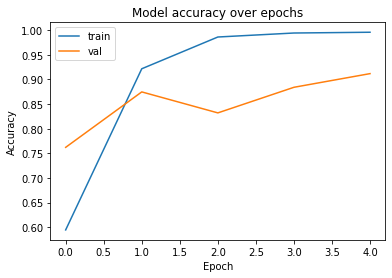

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Confusion matrix and metrics

In [25]:
# Load all batches of validation generator in memory

nb_batches = len(val_gen)
X_val = np.empty((nb_batches, batch_size, frame_length, 1))
y_val = np.empty((nb_batches, batch_size))

for i in range(nb_batches):
    X_val[i], y_val[i] = val_gen.__getitem__(i)

X_val = X_val.reshape((nb_batches * batch_size, -1))
y_val = y_val.reshape(nb_batches * batch_size)

y_val_actual = np.argmax(sincnet_model.predict(X_val), axis=-1)

In [26]:
from sklearn.metrics import precision_recall_fscore_support

# https://en.wikipedia.org/wiki/Precision_and_recall

p, r, f1, _ = precision_recall_fscore_support(y_val,
                                              y_val_actual,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.9139214025327893
Recall: 0.9135845668333507
F1 score: 0.9123389623348618


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcded50f290>)

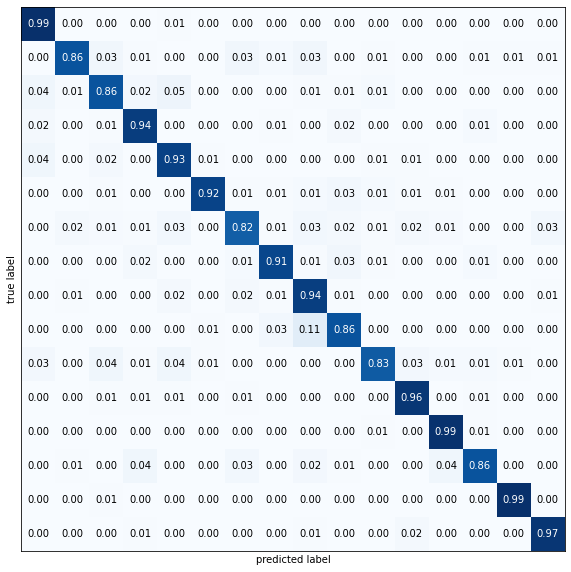

In [39]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_val, y_val_actual)

plot_confusion_matrix(cm,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10),
                      hide_ticks=True)

In [76]:
# confusion for speaker 9 model predicts 8 instead of 9

import IPython
from IPython.display import Audio

s8 = 'LibriSpeech/train-clean-100/4788/294466/4788-294466-0000.flac'
s9 = 'LibriSpeech/train-clean-100/6925/80680/6925-80680-0000.flac'

IPython.display.display(Audio(s8))
IPython.display.display(Audio(s9))

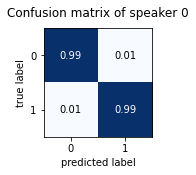

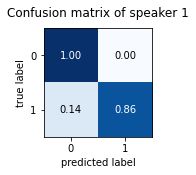

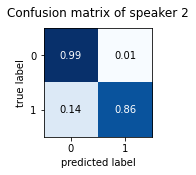

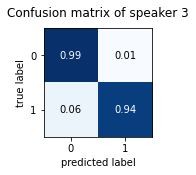

In [54]:
from sklearn.metrics import multilabel_confusion_matrix

cm_per_class = multilabel_confusion_matrix(y_val, y_val_actual)

for i in range(4):
    fig, axs = plot_confusion_matrix(cm_per_class[i],
                                     show_normed=True,
                                     show_absolute=False,
                                     figsize=(2, 2))
    axs.set_title('Confusion matrix of speaker {}'.format(i))

#### Clusterings with PCA

In [77]:
# Select 5 utterances from 5 speakers
nb_utterances_per_speaker = 16
s_ids = [2, 4, 7, 14, 10]

utterances = []
idx_speaker = 0

for i in range(len(s_ids)):
    for j in range(len(X_train)):
        if y_train[j] == s_ids[i] and idx_speaker < nb_utterances_per_speaker:
            path, frame = X_train[j]
            signal, fs = sf.read(path)

            utterances.append(signal[frame:frame+frame_length])
            idx_speaker += 1
    idx_speaker = 0

utterances = np.array(utterances) 

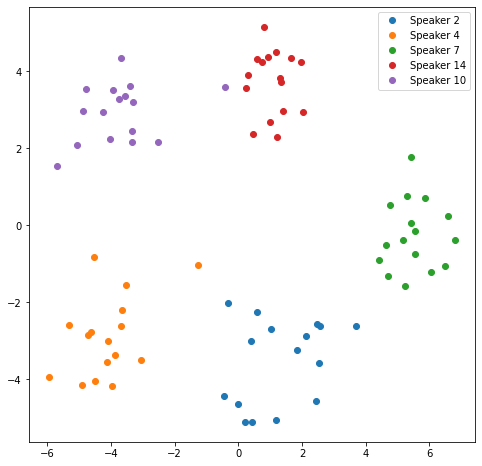

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Get their representation from one of the last layer
layer_name = 'layer_features'
extractor_model = keras.Model(inputs=sincnet_model.input,
                              outputs=sincnet_model.get_layer(layer_name).output)
features = extractor_model(utterances)

# Reduce the dimension to 2D in order to create a plot
features_embedded = PCA(n_components=2).fit_transform(features)
features_embedded = features_embedded.reshape((len(s_ids),
                                               nb_utterances_per_speaker,
                                               2))

# Plot
plt.figure(figsize=(8, 8))
for i in range(len(s_ids)):
    plt.plot(features_embedded[i, :, 0],
             features_embedded[i, :, 1],
             'o',
             label="Speaker {}".format(round(s_ids[i])))

plt.legend(numpoints=1)

#### Compare with similar CNN 1D

In [ ]:
cnn1d_model = create_sincnet(False)

cnn1d_model.compile(optimizer=RMSprop(lr=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

history = cnn1d_model.fit(train_gen,
                          validation_data=val_gen,
                          epochs=5,
                          initial_epoch=0)

Epoch 1/5
80/80 [==============================] - 291s 4s/step - loss: 2.0157 - accuracy: 0.4021 - val_loss: 1.4729 - val_accuracy: 0.5953
Epoch 2/5
80/80 [==============================] - 290s 4s/step - loss: 0.6694 - accuracy: 0.8357 - val_loss: 1.1505 - val_accuracy: 0.7000
Epoch 3/5
80/80 [==============================] - 290s 4s/step - loss: 0.3890 - accuracy: 0.9009 - val_loss: 0.9107 - val_accuracy: 0.7590
Epoch 4/5
80/80 [==============================] - 291s 4s/step - loss: 0.2733 - accuracy: 0.9259 - val_loss: 0.7493 - val_accuracy: 0.7820
Epoch 5/5
80/80 [==============================] - 292s 4s/step - loss: 0.1986 - accuracy: 0.9444 - val_loss: 0.4104 - val_accuracy: 0.8727


In [ ]:
cnn1d_model.evaluate(val_gen)

20/20 [==============================] - 22s 1s/step - loss: 0.4104 - accuracy: 0.8727


[0.41035348176956177, 0.8726562261581421]